# Partie II

Dans cette partie, on se place dans le contexte d'un problème de fusion de données par machine learning. \
Un paramètre physique est estimé à l'aide d'un produit de référence. On suppose que le produit de référence est de très bonne qualité en dehors de certains événements "problématiques".
Par ailleurs, on dispose d'une autre source de données corrélées au paramètre physique d'intérêt. Les données issues de cette source auxiliaire sont particulièrement bruitées, mais les événéments problématiques qu'on évoquait au-dessus ne les affectent pas. \
Sous ces hypothèses, il est naturel de se demander si cette source auxiliaire peut être exploitée pendant les événements problématiques.
Dans cet exercice, nous nous concentrons sur une première étape qui consiste à repérer ces événements à partir des données auxiliaires.

Nous le faisons dans un contexte particulier : le paramètre d'intérêt est le "taux de précipitation". Les cellules de codes suivantes (qu'il n'est pas nécessaire d'étudier) permettront de simuler, d'une façon relativement vraisemblable, l'évolution de ce taux à l'échelle de la minute, celle d'un produit de référence et une série temporelle de données auxiliaires.


**N.B.** L'apprentissage sur carte GPU n'est nécessaire qu'à partir de la question 4. Il vaut mieux attendre cette question avant de l'ajouter à l'environnement d'exécution.

In [1]:
# Imports
import copy
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

In [2]:
# Code nécessaire à la simulation

def simulate_neyman_scott_process_1d(h, theta, p, duration):
    expected_parents = h * duration
    parent_events = np.random.exponential(1/h, int(np.ceil(expected_parents)))
    parent_times = np.cumsum(parent_events)
    parent_times = parent_times[parent_times < duration]

    offspring_times = []

    for parent_time in parent_times:
        num_offspring = np.random.poisson(theta)
        offspring_delays = np.random.randn(num_offspring) * p
        offspring_event_times = parent_time + offspring_delays
        offspring_times.extend(offspring_event_times[(offspring_event_times >= 0) & (offspring_event_times <= duration)])

    return np.sort(parent_times), np.sort(offspring_times)

def smooth_events_with_gaussian_window(event_times, duration, sigma, resolution=1):
    time_series_length = int(duration / resolution)
    event_series = np.zeros(time_series_length)
    for time in event_times:
        if time < duration:
            index = int(time / resolution)
            event_series[index] += 1

    smoothed_series = gaussian_filter1d(event_series, sigma=sigma/resolution, mode='constant')
    times = np.arange(0, duration, resolution)
    return times, smoothed_series


f = lambda x :  0.1*x**0.7
kernel = torch.tensor(np.concatenate([np.arange(0.025,0.5,0.025), np.array([1]), np.zeros(19)]), dtype=torch.float32)


def apply_conv1d_with_custom_kernel(signal, kernel, stride=1):
    signal = signal.unsqueeze(0).unsqueeze(0)
    kernel = kernel.unsqueeze(0).unsqueeze(0)
    padding = (kernel.size(-1) - 1) // 2
    convolved_signal = F.conv1d(signal, kernel, padding=padding, stride=stride)
    convolved_signal = convolved_signal.squeeze(0).squeeze(0)
    return convolved_signal


def generate_random_sinusoidal_process(length, mean_poisson=10., phase_range=(0, 2 * np.pi)):
    num_components = 1 + torch.poisson(torch.tensor([mean_poisson])).int().item()
    coefficients = torch.randn(num_components)
    periods = torch.randint(low=240, high=24*60, size=(num_components,)).float()
    t = torch.linspace(0, length, steps=length)
    signal = torch.zeros(length)

    for i in range(num_components):
        phase = torch.rand(1) * (phase_range[1] - phase_range[0]) + phase_range[0]
        component = coefficients[i] * torch.sin(2 * np.pi * t / periods[i] + phase)
        signal += component
    signal /= num_components
    signal /= 2
    return signal


def get_gaussian_noise(signal, noise_scale_func):
    noise_std = noise_scale_func(signal)
    noise = torch.randn_like(signal) * noise_std
    return noise

def noise_scale_func(signal_intensity):
    return 0.1*torch.abs(1 + signal_intensity) ** 0.75

def modify_random_non_zero_interval(ground_truth, p):
    signal = copy.deepcopy(ground_truth)
    nonzero_indices = torch.where(signal != 0)[0]
    if len(nonzero_indices) == 0:
        return signal

    changes = torch.diff(nonzero_indices) != 1
    interval_starts = torch.cat((nonzero_indices[:1], nonzero_indices[1:][changes]))
    interval_ends = torch.cat((nonzero_indices[:-1][changes], nonzero_indices[-1:]))
    num_intervals = len(interval_starts)
    random_interval_index = torch.randint(0, num_intervals, (1,)).item()
    random_interval_index2 = torch.randint(0, num_intervals, (1,)).item()
    while random_interval_index2 == random_interval_index:
        random_interval_index2 = torch.randint(0, num_intervals, (1,)).item()

    start, end = interval_starts[random_interval_index], interval_ends[random_interval_index]
    signal[start:end+1] *= (1 + p)
    start2, end2 = interval_starts[random_interval_index2], interval_ends[random_interval_index2]
    signal[start2:end2+1] *= (1 - p)
    return start, start2, signal


def generate_data(duration, p=0.5):
    _, event_times = simulate_neyman_scott_process_1d(h=0.05, theta=10., p=3., duration=duration)
    times, smoothed_series = smooth_events_with_gaussian_window(event_times, duration=duration, sigma=2)
    converted_smoothed_series = f(smoothed_series)
    converted_smoothed_series = torch.tensor(converted_smoothed_series, dtype=torch.float32)
    convolved_smoothed_series = apply_conv1d_with_custom_kernel(converted_smoothed_series, kernel, stride=1)

    lf_noise = generate_random_sinusoidal_process(duration)
    hf_noise = get_gaussian_noise(convolved_smoothed_series, noise_scale_func)

    noisy1_series = convolved_smoothed_series + lf_noise

    ground_truth = torch.tensor(smoothed_series, dtype=torch.float32)
    start, start2, reference = modify_random_non_zero_interval(ground_truth, p)
    noisy_series = noisy1_series + hf_noise

    return times, ground_truth, start, start2, reference, noisy_series

La cellule suivante permet de visualiser le résultat d'une simulation.
Les "événements" évoqués dans l'introduction correspondent aux intervalles de temps où le taux de pluie est non-nul.

Comme on le constate en régénérant la figure, le produit de référence simulé est toujours égal à la vérité terrain sauf pour deux événements "problématiques". Pour le premier de ces événements, le taux de précipitation est largement surestimé, pour le second, c'est l'inverse.

début de l événement au cours duquel le taux de pluie est surestimé par le produit de référence :  139
début de l événement au cours duquel le taux de pluie est sous-estimé par le produit de référence :  415


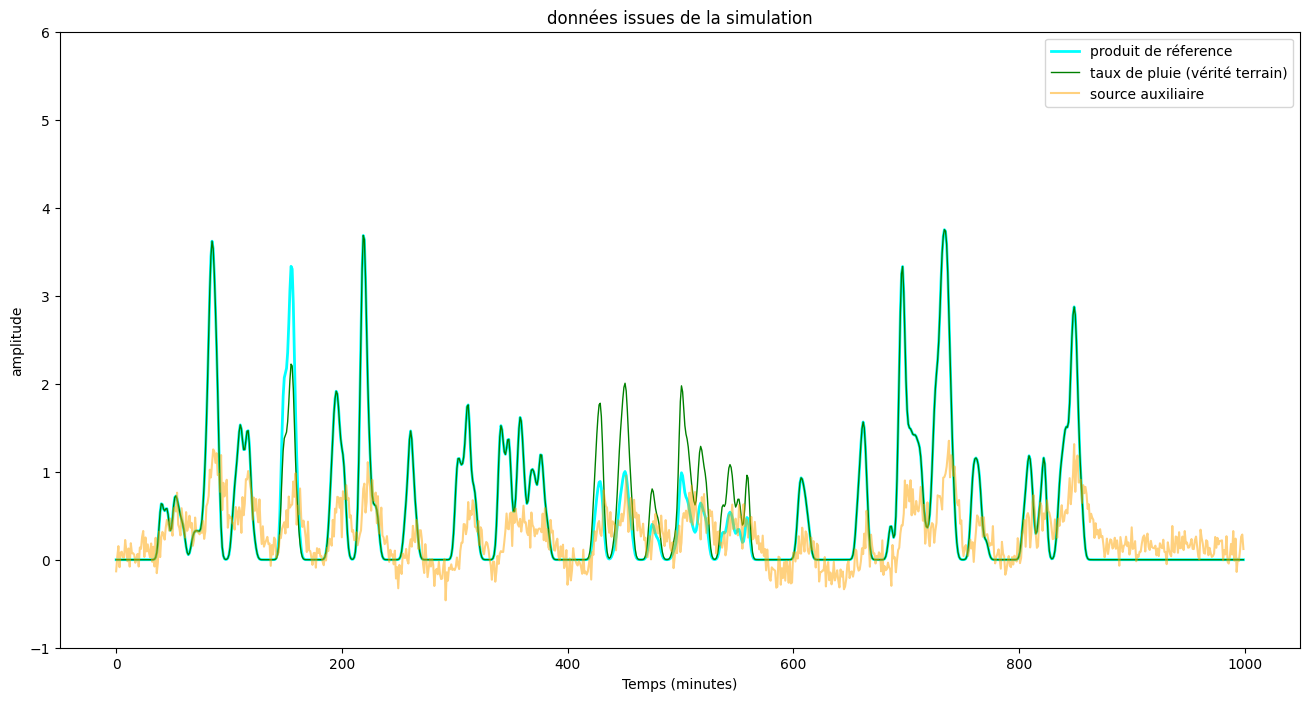

In [3]:
times, ground_truth, start, start2, reference, aux = generate_data(1000)

print("début de l événement au cours duquel le taux de pluie est surestimé par le produit de référence : ", start.item())
print("début de l événement au cours duquel le taux de pluie est sous-estimé par le produit de référence : ", start2.item())

plt.figure(figsize=(16, 8))
plt.plot(times, reference, label='produit de réference', color='cyan', alpha=1., linewidth=2)
plt.plot(times, ground_truth, label='taux de pluie (vérité terrain)', color='green', alpha=1., linewidth=1)
plt.plot(times, aux, label='source auxiliaire', color='orange', alpha=0.5)
plt.title(f'données issues de la simulation')
plt.xlabel('Temps (minutes)')
plt.ylabel('amplitude')
plt.ylim(-1,6)
plt.legend()
plt.show()

**Q1** Ci-dessous, la classe SimulatedDataset enrobe la fonction generate_data dans un Dataset pytorch. La fonction create_dataloader fournit un Dataloader  qui regroupe les séries de données générées de manière indépendante en "mini-batches".
Expliquer en quelques mots la raison pour laquelle ces "mini-batches" sont formés.

In [5]:
class SimulatedDataset(Dataset):
    def __init__(self, duration, num_samples):
        self.duration = duration
        self.num_samples = num_samples

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        _, ground_truth, start, start2, reference, aux = generate_data(self.duration)
        # "Normalisation"
        aux *= 0.3
        return ground_truth, start, start2, reference, aux

def create_dataloader(duration, num_samples, batch_size):
    dataset = SimulatedDataset(duration, num_samples)
    dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=0)
    return dataloader


duration = 1024  # durée d'une simulation individuelle
num_samples = 2048
batch_size = 64

dataloader = create_dataloader(duration, num_samples, batch_size)


# Séparer en mini-batches permet de faciliter et d'accélérer l'entraînelent du modèle

**Q2** La cellule suivante représente une "époque". Combien de batches sont tirés ? Quelle variable contrôle cette quantité ?

In [6]:
# "Parcours" du jeu de données
for batch_idx, (ground_truth, start, start2, reference, aux) in enumerate(dataloader):
  pass

Nb_batches = num_samples/batch_size = 2048/64=32

**Q3** Le code ci-dessous permet de construire une architecture de type U-Net pour traiter des images. Décrire brièvement ce type d'architecture puis modifier le code de manière à traiter des séries temporelles.

Vérifier son bon fonctionnement en passant le modèle sur un batch de données issues de la source auxiliaire.

UNet : Sa structure d'encodeur va permettre d'extraire les caractéristiques pertinentes de l'image . Le décodeur va permettre de reconstituer une carte de segmentation de la même taille que l'image d'origine.

In [11]:
## Briques de base

class double_conv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm1d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv1d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm1d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x



class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class Down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(Down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool1d(2),
            double_conv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x


class Up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=False):
        super(Up, self).__init__()
        self.up = nn.ConvTranspose1d(in_ch, in_ch, kernel_size=2, stride=2)
        self.conv = double_conv(2*in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffX = x1.size()[2] - x2.size()[2]
        x2 = F.pad(x2, (diffX // 2, diffX - diffX // 2))

        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv1d(in_ch, out_ch, 1)


    def forward(self, x):
        x = self.conv(x)
        return x


## Réseau U-Net

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes,size=64):
        super(UNet, self).__init__()
        self.inc = inconv(n_channels, size)
        self.down1 = Down(size, 2*size)
        self.down2 = Down(2*size, 4*size)
        self.down3 = Down(4*size, 8*size)
        self.down4 = Down(8*size, 8*size)
        self.up1 = Up(8*size, 4*size)
        self.up2 = Up(4*size, 2*size)
        self.up3 = Up(2*size, size)
        self.up4 = Up(size, size)
        self.outc = outconv(size, n_classes)
        self.n_classes=n_classes

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        del x4, x5
        x = self.up2(x, x3)
        del x3
        x = self.up3(x, x2)
        del x2
        x = self.up4(x, x1)
        del x1
        x = self.outc(x)
        return   x


model = UNet(1, 1, 16)

Dimensions de la sortie : torch.Size([64, 1, 1024])


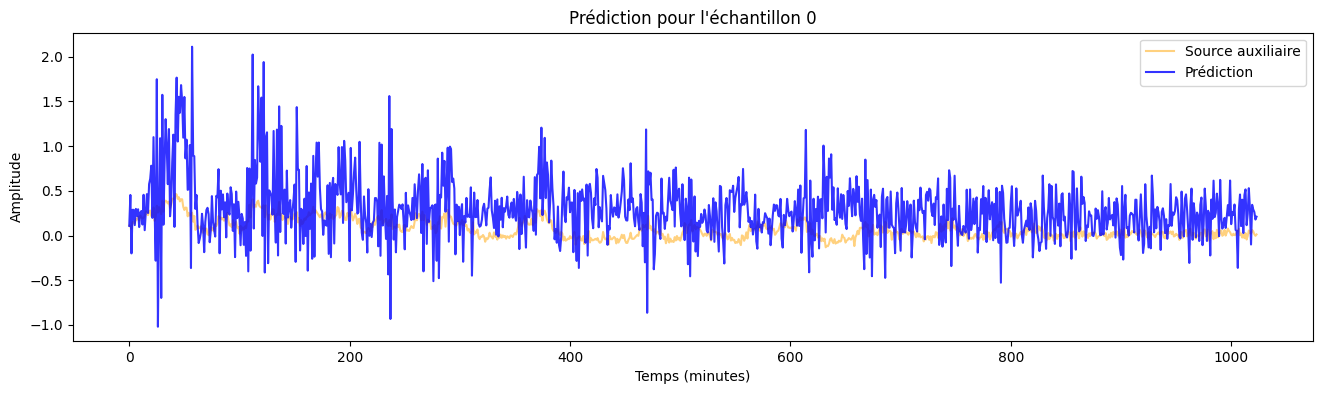

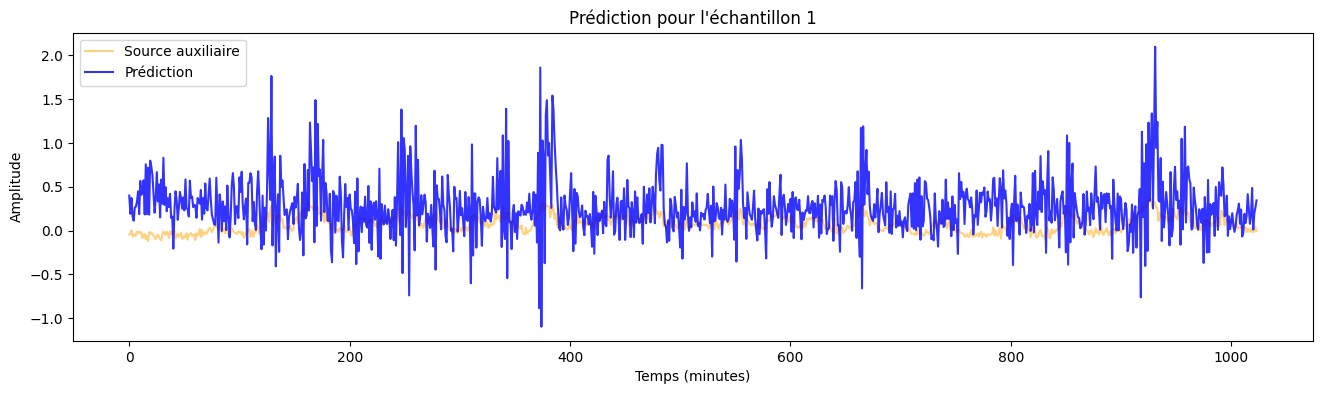

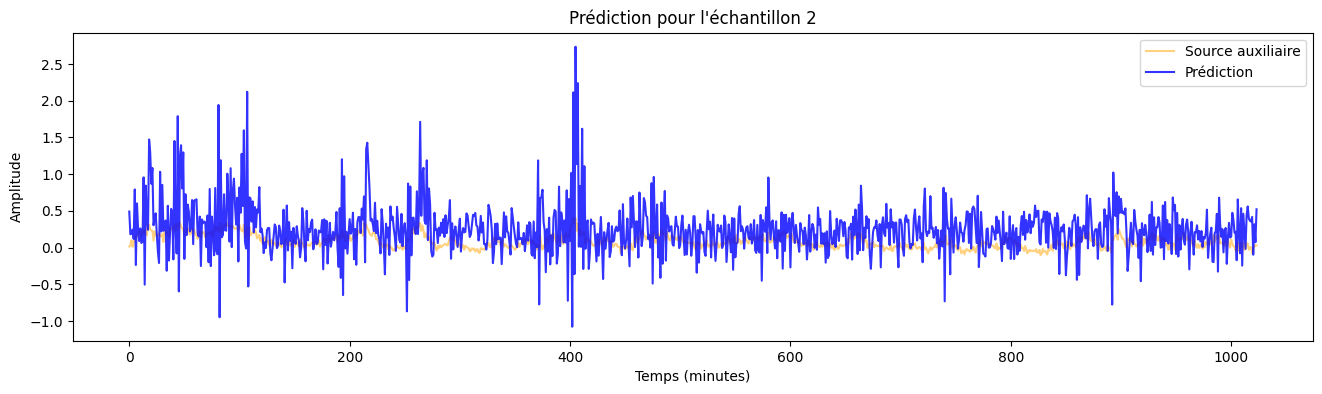

In [12]:
# Charger un batch de données depuis le dataloader
for batch_idx, (ground_truth, start, start2, reference, aux) in enumerate(dataloader):
    break  # On prend seulement le premier batch

# Sélectionner les données auxiliaires comme entrée du modèle
inputs = aux.unsqueeze(1).float()  # Ajouter une dimension pour le nombre de canaux

# Déplacer les données vers le périphérique approprié (CPU ou GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
inputs = inputs.to(device)
model = model.to(device)

# Passer les données au modèle
with torch.no_grad():  # Désactiver le calcul des gradients pour l'inférence
    outputs = model(inputs)

# Vérifier les dimensions de la sortie
print("Dimensions de la sortie :", outputs.shape)

# Afficher quelques exemples de prédictions
# (Vous pouvez adapter cette partie selon vos besoins)
for i in range(3):
    plt.figure(figsize=(16, 4))
    plt.plot(aux[i], label='Source auxiliaire', color='orange', alpha=0.5)
    plt.plot(outputs[i].squeeze().cpu(), label='Prédiction', color='blue', alpha=0.8)
    plt.title(f'Prédiction pour l\'échantillon {i}')
    plt.xlabel('Temps (minutes)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.show()

**Q4** Une première approche consiste à estimer une valeur de taux de pluie à partir des liens par régression, puis à chercher les événements "problématiques" parmi ceux pendant lesquels l'estimation est relativement éloignée du produit de référence.

Entraîner le U-Net précédent avec :
- comme entrées, les séries temporelles issues de la source auxiliaire.
- comme cibles, les séries issues du produit de référence.
- comme fonction de coût, l'écart absolu moyen.
- l'optimizer Adam avec les paramètres standards.
- 25 époques, chacune limitée à la phase d'entraînement.

**N.B** On vérifiera d'abord sur deux époques que la fonction de coût décroit effectivement, puis on relancera l'apprentissage avec une carte GPU V100 à disposition (3-4 minutes). On répondra aux questions **5** et **6** pendant l'apprentissage.

In [15]:
import torch.optim as optim
model = UNet(1, 1, 16).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
num_epochs = 25

optimizer = torch.optim.Adam(model.parameters())
criterion = nn.L1Loss()

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for epoch in range(num_epochs):
    running_loss = 0.0
    for batch_idx, (ground_truth, start, start2, reference, aux) in enumerate(dataloader):

        # Attention à la dimension associée au nombre de canaux (utiliser unsqueeze pour l'ajouter)

        inputs, targets = aux.to(device).unsqueeze(1).float(), \
                          reference.to(device).unsqueeze(1).float()

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader):.4f}')

Epoch [1/25], Loss: 0.3010
Epoch [2/25], Loss: 0.1634
Epoch [3/25], Loss: 0.1536
Epoch [4/25], Loss: 0.1504
Epoch [5/25], Loss: 0.1505
Epoch [6/25], Loss: 0.1469
Epoch [7/25], Loss: 0.1493
Epoch [8/25], Loss: 0.1484
Epoch [9/25], Loss: 0.1475
Epoch [10/25], Loss: 0.1473
Epoch [11/25], Loss: 0.1472
Epoch [12/25], Loss: 0.1472
Epoch [13/25], Loss: 0.1474
Epoch [14/25], Loss: 0.1460
Epoch [15/25], Loss: 0.1467
Epoch [16/25], Loss: 0.1468
Epoch [17/25], Loss: 0.1448
Epoch [18/25], Loss: 0.1455
Epoch [19/25], Loss: 0.1445
Epoch [20/25], Loss: 0.1466
Epoch [21/25], Loss: 0.1459
Epoch [22/25], Loss: 0.1454
Epoch [23/25], Loss: 0.1449
Epoch [24/25], Loss: 0.1442
Epoch [25/25], Loss: 0.1445


**Q5** Quel est en général le rôle d'une phase de validation pendant un apprentissage ? Pourquoi peut-on s'en passer ici ?

Rôle d'une phase de validation : évaluer les performances du modèle sur des données qu'il n'a jamais vues pendant l'entraînement. Cette phase permet de détecter le surapprentissage, de choisir les hyperparamètres et d'arrêter l'entraînement au bon moment .

On peut s'en passer ici car les données utilisées pour l'entraînement sont simulées.

**Q6** Pourquoi a-t-on ciblé le produit de référence plutôt que la vérité terrain ? Qu'est-ce qui permet d'espérer que l'estimation obtenue par régression différera davantage du produit de référence pendant les événements "problématiques" ?

Vérité terrain pas toujours accessible

L'objectif de base est de déterminer les évènements problématiques ie les moments ou le produit de référence est erroné. On apprend donc au modèle à faire le lien entre la source auxiliaire et le produit de référence,ce qui permettra de mieux identifier les évènements problématiques.


Les sources auxiliaires ne sont pas affectées par les évènements problématiques


    Pendant les périodes normales, le modèle apprendra la relation entre la source auxiliaire et le produit de référence, qui sont alors tous deux relativement précis.
    Pendant les événements problématiques, le produit de référence sera erroné, tandis que la source auxiliaire restera fiable. Le modèle, ayant appris la relation "normale" entre les deux, produira une estimation qui sera proche de ce que le produit de référence devrait être en se basant sur la source auxiliaire.
    Cette estimation différera donc du produit de référence erroné, permettant ainsi de détecter l'anomalie.


**Q7** Visualiser les prédictions du réseau à l'aide de la fonction suivante et commenter.

In [17]:
def visualize_predictions(model, data_loader):
    model.eval()
    with torch.no_grad():
        for batch_idx, (ground_truth, start, start2, reference, aux) in enumerate(dataloader):

            inputs = aux.to(device).unsqueeze(1).float()  # Adjust input dimensions
            outputs = model(inputs).cpu()

            for i in range(3):
                plt.figure(figsize=(16, 4))
                plt.plot(reference[i], label='produit de réference', color='cyan', alpha=1., linewidth=2)
                plt.plot(ground_truth[i], label='taux de pluie (vérité terrain)', color='green', alpha=1., linewidth=1)
                plt.plot(outputs[i].squeeze(), label='Prediction', color='orange', alpha=0.5, linestyle='--')
                plt.title(f'prédiction')
                plt.xlabel('Temps (minutes)')
                plt.ylabel('amplitude')
                plt.ylim(-1,6)
                plt.legend()
                plt.show()
            break



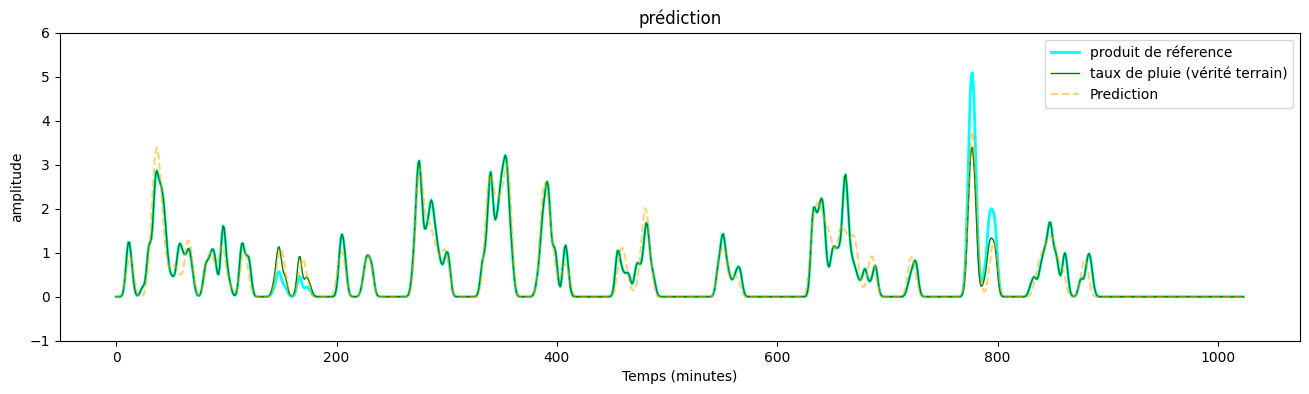

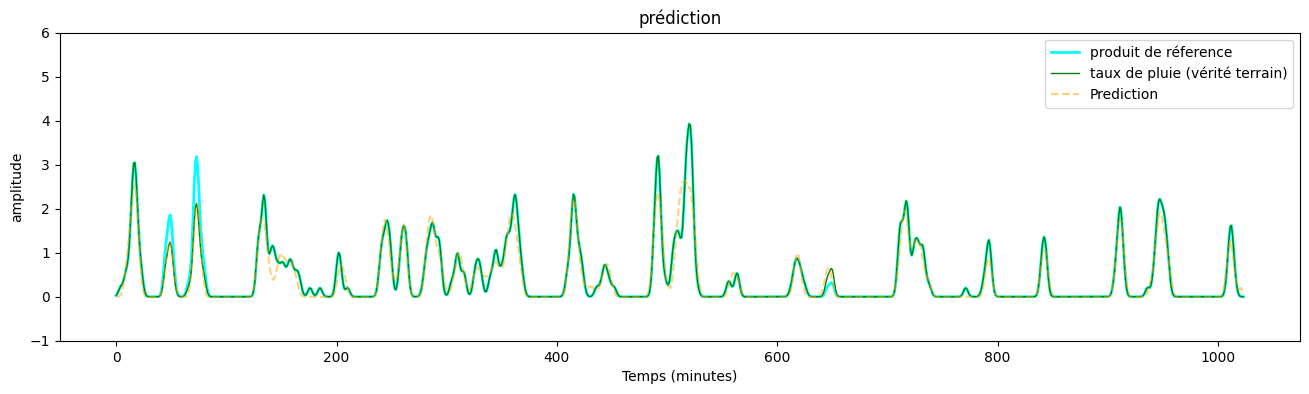

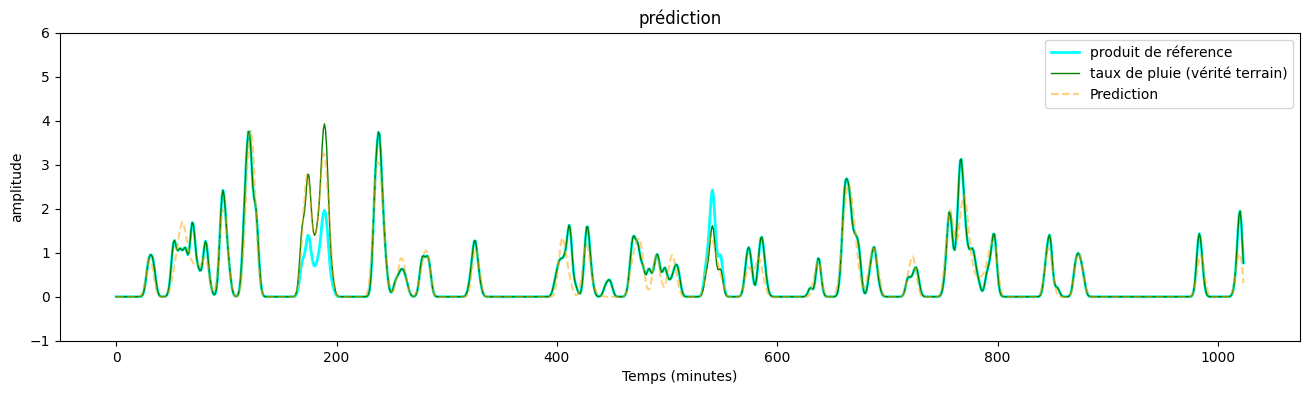

In [18]:
visualize_predictions(model, dataloader)

**Q8** La fonction *mean_error_per_non_zero_interval* suivante permet d'associer à chaque début d'événément l'écart moyen entre la prédiction et le produit de référence pendant cet événement.

Compléter la fonction *score_anomaly_detection* de manière à déterminer, pour toutes les séries temporelles d'une époque, la fréquence à laquelle les deux événements marqués par l'écart moyen le plus important correspondent effectivement aux événements problématiques.

**N.B.** *start* et *start2* contiennent les débuts des événements problématiques.

In [ ]:
def mean_error_per_non_zero_interval(ground_truth, reference, prediction):
    # Recherche des événements (plages de valeurs non-nulles)
    nonzero_positions = ground_truth.nonzero(as_tuple=True)[0]
    if len(nonzero_positions) == 0:
        return []

    diffs = torch.diff(nonzero_positions)
    boundaries = torch.where(diffs > 1)[0]
    # débuts des événements
    interval_starts = torch.cat((nonzero_positions[:1], nonzero_positions[boundaries + 1]))
    # fins
    interval_ends = torch.cat((nonzero_positions[boundaries], nonzero_positions[-1:]))

    # Calcul de l'écart moyen entre prédiction et produit de référence pendant les événements
    intervals_MAE = []
    for start, end in zip(interval_starts, interval_ends):
        MAE = torch.mean(torch.abs((prediction[start:end + 1] - reference[start:end + 1]))).item()
        intervals_MAE.append((start.item(), MAE))

    return intervals_MAE



In [ ]:
def score_anomaly_detection(model, data_loader):
    model.eval()
    anomaly_prediction = []
    with torch.no_grad():
        for batch_idx, (ground_truth, start, start2, reference, aux) in enumerate(dataloader):
            inputs = aux.to(device).unsqueeze(1).float()
            outputs = model(inputs).cpu()
            for i in range(reference.shape[0]): # Parcours les séries du batch
                starti = int(start[i].item())
                start2i = int(start2[i].item())

                intervals_MAE = mean_error_per_non_zero_interval(ground_truth[i].squeeze(), ...

                ...

                anomaly_prediction.append( ...


    print(np.mean(anomaly_prediction))


score_anomaly_detection(model, dataloader)

**Q9** Une approche plus fine consiste à déterminer le caractère anormal d'une valeur de référence non par son écart à la prédiction, mais par sa probabilité d'occurrence *sachant* les données auxiliaires.
Il n'est pas facile d'estimer cette probabilité conditionnelle, mais le concept de régression quantile vu au **TP N°5 partie I** nous permet d'en donner un encadrement.
Précisément, la procédure d'apprentissage vue à l'**exercice 3** permet d'estimer  simultanément tous les centiles de la distribution.

Les objets utiles ont été adaptés au cas de séries temporelles dans la cellule ci-dessous. Reprendre la procédure d'apprentissage de l'**exercice 3** et l'appliquer sur les données sans changer le dataloader ni les hyperparamètres.

In [ ]:
def dot1d(t, M):
	return (M * t.view((1,t.shape[0],1)) ).sum(dim=1)

class QuantileLoss1d(torch.nn.Module):

    def __init__(self , n):
        super(QuantileLoss1d, self).__init__()
        self.n = n   # n= 100 -> centiles
        self.t = torch.arange(1/n,1,1/n).cuda()  # quantile orders

    def forward(self, output, target):
        bs, _, nx = target.shape
        d = target.view(bs, 1, nx) - output
        loss_by_pix = dot1d(self.t , d.clamp(min =0)) \
                      + dot1d(self.t - 1 , d.clamp(max =0))
        loss = torch.mean(loss_by_pix)

        return loss

In [ ]:
n = 100
model = UNet(1, ... , 16)
num_epochs = 25
...

In [ ]:
for epoch in range(num_epochs):
    running_loss = 0.0
    for batch_idx, (ground_truth, start, start2, reference, aux) in enumerate(dataloader):

        inputs, targets = aux.to(device), \
                          reference.to(device)

        ...

        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader):.4f}')

**Q10** Après apprentissage, le modèle estime des quantiles conditionnels pour chaque élément de la série temporelle en entrée. On rappelle que l'ordre du quantile est fourni par l'index de la ligne : dans le cas de centiles, la dernière ligne fournit le quantile d'ordre 0.99 tandis que la ligne d'indice 49 fournit l'estimation de la médiane.

La fonction *find_nearest_quantile_indices* permet de préciser l'ordre du quantile le plus proche de la référence à chaque pas de temps.

Pour juger du caractère anormal d'un événement, on se propose de déterminer l'écart moyen entre l'ordre du quantile le plus proche de la référence et 0,5. C'est ce que permet la fonction *mean_quantile_per_non_zero_interval*.

Compléter la fonction *score_anomaly_detection2* de manière à déterminer, pour toutes les séries temporelles d'une époque, la fréquence à laquelle les deux événements marqués par l'écart moyen le plus important correspondent effectivement aux événements problématiques.

Conclure.

In [ ]:
def find_nearest_quantile_indices(quantiles, target):

    # Calcul de l'écart entre quantiles et cible (référence)
    diff = torch.abs(quantiles - target.unsqueeze(0))

    # Initialisation du vecteur des odres des quantiles les plus proches
    nearest_quantile_indices = torch.empty(target.shape, dtype=torch.long)

    # Pour chaque pas de temps, on va chercher l'ordre du quantile le plus proche
    # de la référence
    for i in range(target.shape[0]):
        column_diff = diff[:, i]
        min_diff = torch.min(column_diff)
        min_indices = torch.where(column_diff == min_diff)[0]
        nearest_quantile_indices[i] = min_indices[0] / 100.

    return nearest_quantile_indices


def mean_quantile_per_non_zero_interval(ground_truth, quantile_order):
    # Recherche des événements (plages de valeurs non-nulles)
    nonzero_positions = ground_truth.nonzero(as_tuple=True)[0]
    if len(nonzero_positions) == 0:
        return []

    diffs = torch.diff(nonzero_positions)
    boundaries = torch.where(diffs > 1)[0]
    # débuts des événements
    interval_starts = torch.cat((nonzero_positions[:1], nonzero_positions[boundaries + 1]))
    # fins
    interval_ends = torch.cat((nonzero_positions[boundaries], nonzero_positions[-1:]))

    # Calcul de l'écart moyen entre l'ordre du quantile associé à la réf et 0,5
    intervals_info = []
    for start, end in zip(interval_starts, interval_ends):
        interval_quantile_orders = quantile_order[start:end + 1]
        mean_quantile_order = torch.mean(interval_quantile_orders).item()
        intervals_info.append((start.item(), np.abs(mean_quantile_order-0.5)))

    return intervals_info

def score_anomaly_detection2(model, data_loader):
    model.eval()
    anomaly_prediction = []
    with torch.no_grad():
        for batch_idx, (ground_truth, start, start2, reference, aux) in enumerate(dataloader):

            inputs = aux.to(device).unsqueeze(1).float()
            outputs = model(inputs).cpu()
            for i in range(reference.shape[0]): # Parcourt les séries du batch
                nearest_quantile = find_nearest_quantile_indices( ... )
                intervals_info = mean_quantile_per_non_zero_interval( ... )

                ...

                anomaly_prediction.append( ...

    print(np.mean(anomaly_prediction))


score_anomaly_detection2(model, dataloader)

